Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
from evaluate import plot_confusion_matrix, plot_feature_importance, plot_parameter_sensitivity, get_results, get_cross_validation_scores
from preprocess import prepare_loan_train_test, preprocess_loan_features, get_feature_splits, make_linear_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
import time

## BaseModel

In [5]:
training_data = pd.read_csv("loan-10k.lrn.csv") 
training_data = preprocess_loan_features(training_data)
X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=True)

              precision    recall  f1-score   support

           A       0.40      0.88      0.55       364
           B       0.51      0.35      0.41       576
           C       0.59      0.33      0.42       598
           D       0.49      0.16      0.24       290
           E       0.26      0.27      0.27       124
           F       0.06      0.24      0.10        37
           G       0.07      0.64      0.12        11

    accuracy                           0.41      2000
   macro avg       0.34      0.41      0.30      2000
weighted avg       0.48      0.41      0.40      2000



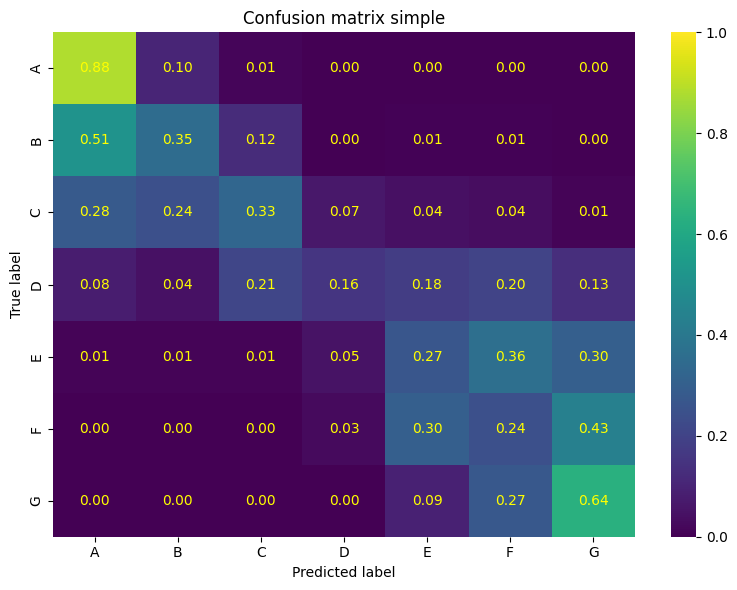

In [6]:
target_names = ["A","B", "C", "D", "E", "F", "G"]
ridge_model = RidgeClassifier(class_weight= 'balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

## Base model without estimating intercept


              precision    recall  f1-score   support

           A       0.40      0.88      0.55       364
           B       0.51      0.34      0.41       576
           C       0.59      0.33      0.42       598
           D       0.49      0.16      0.24       290
           E       0.26      0.27      0.26       124
           F       0.07      0.27      0.11        37
           G       0.07      0.64      0.12        11

    accuracy                           0.41      2000
   macro avg       0.34      0.41      0.30      2000
weighted avg       0.49      0.41      0.40      2000



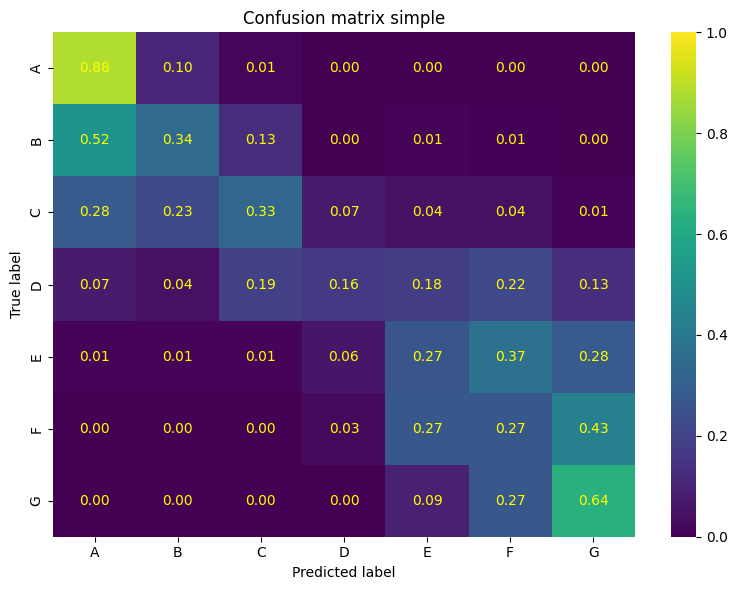

In [7]:
ridge_model_nointercept = RidgeClassifier(class_weight= 'balanced', fit_intercept= False, random_state=42)
ridge_model_nointercept.fit(X_train, y_train)

y_pred_ridge = ridge_model_nointercept.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

## Base model cross-val scores and hyperparam optimalization

In [8]:
get_cross_validation_scores(ridge_model, X_train, y_train )

10-Fold CV Scores: [0.40048516 0.38038952 0.38514861 0.39174962 0.3801935  0.38571065
 0.35648262 0.39424072 0.38506553 0.37521111]
Average f1_weighted Score: 0.3835
Standard Deviation: 0.0114


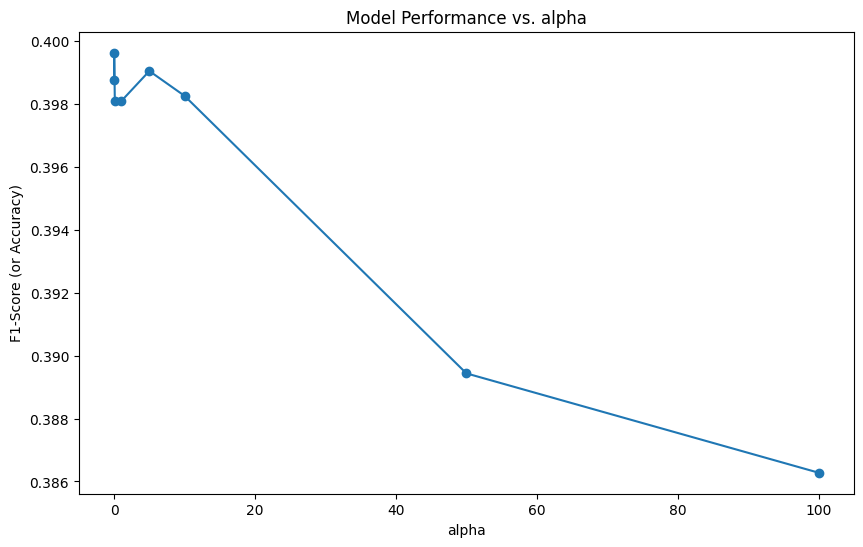

Alpha Values Tested: [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
Weighted F1 Scores: ['0.3987', '0.3996', '0.3981', '0.3981', '0.3990', '0.3983', '0.3894', '0.3863']


In [9]:
f1_scores_ridge = []
param_range = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
# Iterate through the alpha values
for alpha_val in param_range:
    # Instantiate the RidgeClassifier with the current alpha
    ridge_exp = RidgeClassifier(
        alpha=alpha_val,  # Set the current alpha value
        class_weight='balanced',
        random_state=42
    )
    
    # Train the model
    ridge_exp.fit(X_train, y_train)
    
    # Generate the classification report
    report = classification_report(
        y_val, 
        ridge_exp.predict(X_val), 
        output_dict=True
    )
    
    # Store the weighted F1-score
    f1_scores_ridge.append(report['weighted avg']['f1-score'])

# 3. Plot the results
# The plotting logic is simpler for Ridge as there's no 'None' value
plot_parameter_sensitivity(
    param_values=param_range, 
    scores=f1_scores_ridge, 
    param_name="alpha"
)

# Optional: Print results
print("Alpha Values Tested:", param_range)
print("Weighted F1 Scores:", [f"{score:.4f}" for score in f1_scores_ridge])

In [10]:

index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

model_name = 'ridge_weights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.005975027999960293)}
Best F1-score: 0.3805


Optimal alpha: 0.005975027999960293


              precision    recall  f1-score   support

           A       0.40      0.89      0.55       364
           B       0.51      0.35      0.41       576
           C       0.59      0.33      0.43       598
           D       0.49      0.16      0.24       290
           E       0.25      0.25      0.25       124
           F       0.06      0.24      0.10        37
           G       0.07      0.64      0.12        11

    accuracy                           0.41      2000
   macro avg       0.34      0.41      0.30      2000
weighted avg       0.49      0.41      0.40      2000



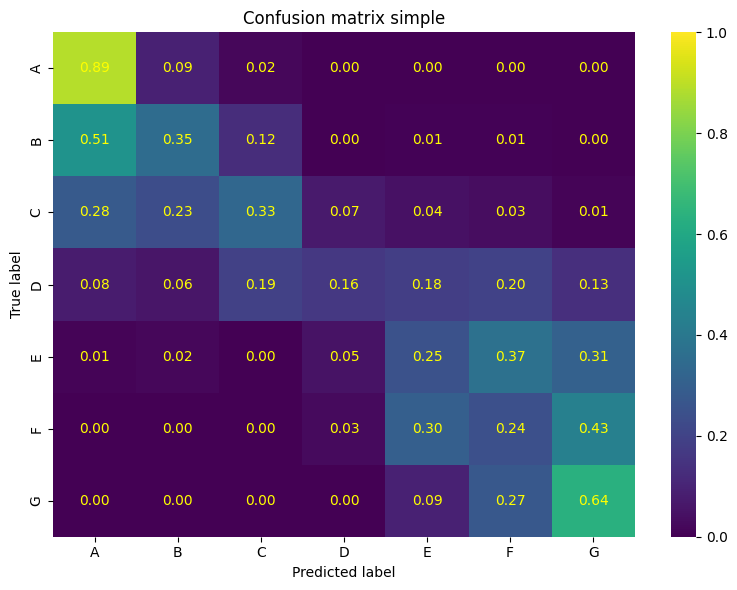

In [11]:
y_pred_ridge_opt = final_model.predict(X_val)
get_results(y_val, y_pred_ridge_opt, target_names)

## Base model without balanced weights

/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

           A       0.58      0.62      0.60       364
           B       0.57      0.64      0.60       576
           C       0.53      0.67      0.60       598
           D       0.29      0.20      0.24       290
           E       0.33      0.02      0.05       124
           F       0.00      0.00      0.00        37
           G       0.00      0.00      0.00        11

    accuracy                           0.53      2000
   macro avg       0.33      0.31      0.30      2000
weighted avg       0.49      0.53      0.50      2000



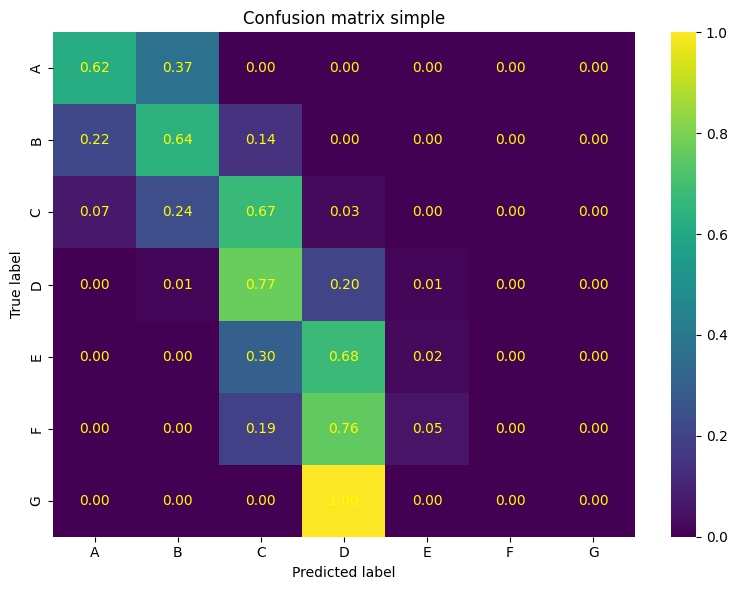

In [12]:
ridge_model_noweights = RidgeClassifier(random_state=42)
ridge_model_noweights.fit(X_train, y_train)

y_pred_ridge = ridge_model_noweights.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

In [13]:
get_cross_validation_scores(ridge_model_noweights, X_train, y_train )

10-Fold CV Scores: [0.50414185 0.5293054  0.50612376 0.51058631 0.49024852 0.5065997
 0.46510926 0.52358447 0.49552998 0.50179277]
Average f1_weighted Score: 0.5033
Standard Deviation: 0.0169


In [14]:
model_name = 'ridge_noweights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model_noweights,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.002323350351539011)}
Best F1-score: 0.5027


              precision    recall  f1-score   support

           A       0.58      0.64      0.61       364
           B       0.57      0.63      0.60       576
           C       0.54      0.68      0.60       598
           D       0.30      0.21      0.25       290
           E       0.33      0.02      0.03       124
           F       0.00      0.00      0.00        37
           G       0.00      0.00      0.00        11

    accuracy                           0.53      2000
   macro avg       0.33      0.31      0.30      2000
weighted avg       0.50      0.53      0.50      2000



/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

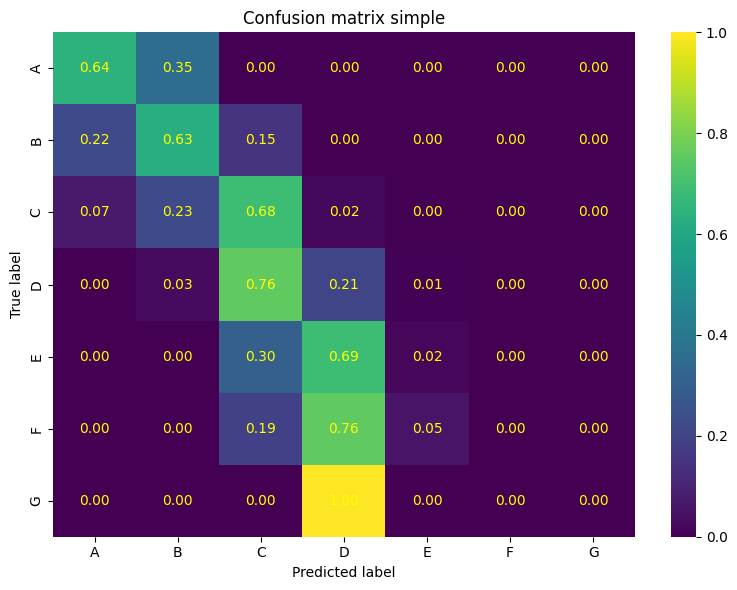

In [15]:
y_pred_ridge_opt = final_model.predict(X_val)
get_results(y_val, y_pred_ridge_opt, target_names)

## Unscaled data

In [17]:
training_data = pd.read_csv("loan-10k.lrn.csv") 
training_data = preprocess_loan_features(training_data)
X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=False)


              precision    recall  f1-score   support

           A       0.40      0.89      0.55       364
           B       0.51      0.34      0.41       576
           C       0.59      0.33      0.42       598
           D       0.48      0.16      0.24       290
           E       0.25      0.25      0.25       124
           F       0.07      0.27      0.11        37
           G       0.07      0.64      0.12        11

    accuracy                           0.41      2000
   macro avg       0.34      0.41      0.30      2000
weighted avg       0.48      0.41      0.40      2000



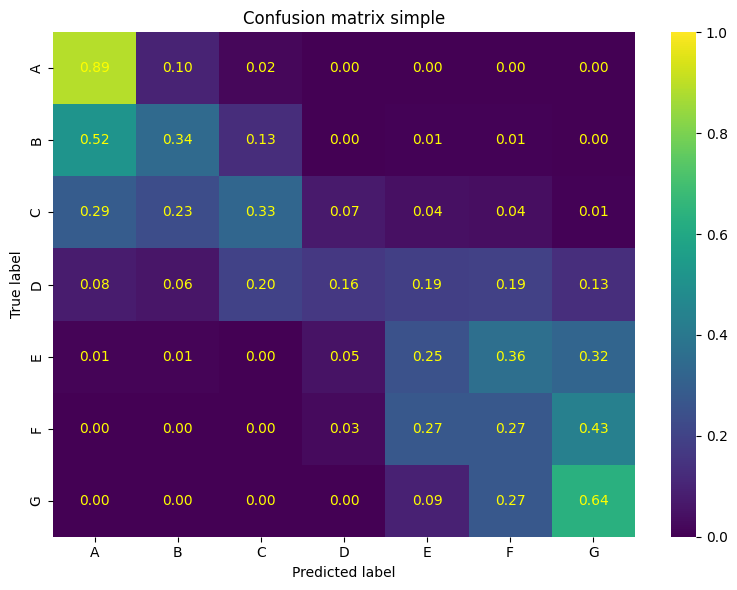

In [18]:
target_names = ["A","B", "C", "D", "E", "F", "G"]
ridge_model = RidgeClassifier(class_weight= 'balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

In [19]:
model_name = 'ridge_unscaled'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.23174e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.32584e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22841e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.23487e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (r

Best parameters found: {'alpha': np.float64(0.00115279871282324)}
Best F1-score: 0.3820


/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.57925e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


              precision    recall  f1-score   support

           A       0.40      0.88      0.55       364
           B       0.51      0.34      0.41       576
           C       0.59      0.33      0.42       598
           D       0.49      0.17      0.25       290
           E       0.23      0.23      0.23       124
           F       0.07      0.24      0.10        37
           G       0.07      0.64      0.12        11

    accuracy                           0.40      2000
   macro avg       0.34      0.40      0.30      2000
weighted avg       0.48      0.40      0.40      2000



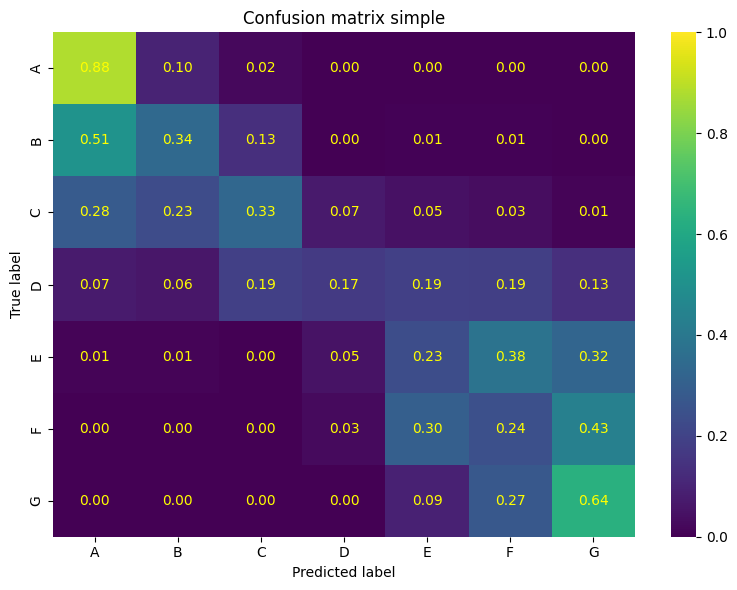

In [20]:
y_pred_ridge_opt = final_model.predict(X_val)
get_results(y_val, y_pred_ridge_opt, target_names)

In [3]:
df = pd.read_csv("loan-10k.lrn.csv")

# Feature/target és oszloptípusok felosztása
X, y, num_cols, cat_cols = get_feature_splits(
    df, target_col="grade", id_col="ID"
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
target_names = ["A","B","C","D","E","F","G"]
ridge_model = make_linear_pipeline(
    RidgeClassifier(class_weight='balanced', random_state=42),
    num_cols, cat_cols
)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_val)
get_results(y_val, y_pred_ridge, target_names)


ValueError: could not convert string to float: 'N'